In [1]:
import torch
import torch.nn as nn
import pandas as pd
import scipy.sparse as sp
import numpy as np
from tqdm import  tqdm
import torch.optim as optim
import math

In [2]:
import os
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.enabled = True
seed_everything(42)

### Verify Pytorch's version

In [3]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.3.0a0+6ddf5cf85e.nv24.04


### Take a quick look of the training dataset

In [4]:
data = pd.read_table("Data/ml-1m.train.rating",sep="\t",header=None)
data.head(5)

,0,1,2,3
0,0,32,4,978824330
1,0,34,4,978824330
2,0,4,5,978824291
3,0,35,4,978824291
4,0,30,4,978824291


## Define NCF

In [5]:
class NCF(object):
    def __init__(self, config):
        self.config = config
        self._num_users = config['num_users']
        self._num_items = config['num_items']
        self._X = config['layer_X']
        self._factor = config['factor']
        self._embedding_size_gmf = self._factor
        self._embedding_size_mlp = self._factor*(2**(self._X-1))

        self._embedding__user_gmf = nn.Embedding(self._num_users, self._embedding_size_gmf)
        self._embedding__item_gmf = nn.Embedding(self._num_items, self._embedding_size_gmf)

        if self._X > 0:
            self._embedding__user_mlp = nn.Embedding(self._num_users, self._embedding_size_mlp)
            self._embedding__item_mlp = nn.Embedding(self._num_items, self._embedding_size_mlp)

            self._fc_layers = nn.ModuleList()
            for idx in range(self._X-1, -1, -1):
                in_size = self._factor*(2**(idx+1))
                out_size = self._factor*(2**idx)
                self._fc_layers.append(nn.Linear(in_size, out_size))
        self._out_fc = nn.Linear(self._factor, 1, bias=False)
        
        self._activate1 = nn.Sigmoid()
        self._activate2 = nn.ReLU()
    def __repr__(self):
        return ""

### GMF

In [6]:
class GMF(NCF,nn.Module):
    def __init__(self, config):
        nn.Module.__init__(self)
        NCF.__init__(self, config)

    def forward(self, user_idx, item_idx):
        user_embedding = self._embedding__user_gmf(user_idx)
        item_embedding = self._embedding__item_gmf(item_idx)
        pointwise_vector = torch.mul(user_embedding, item_embedding)
        logit = self._out_fc(pointwise_vector)
        prob = self._activate1(logit)
        return prob.squeeze(1)

### MLP

In [7]:
class MLP(NCF,nn.Module):
    def __init__(self, config):
        nn.Module.__init__(self)
        NCF.__init__(self, config)

    def forward(self, user_idx, item_idx):
        user_embedding = self._embedding__user_mlp(user_idx)
        item_embedding = self._embedding__item_mlp(item_idx)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for _, layer in enumerate(self._fc_layers):
            vector = layer(vector)
            vector = self._activate2(vector)
        logit = self._out_fc(vector)
        prob = self._activate1(logit)
        return prob.squeeze(1)

### NeuMF

In [8]:
class NeuMF(NCF,nn.Module):
    def __init__(self, config):
        nn.Module.__init__(self)
        NCF.__init__(self, config)
        self._neumf_fc = nn.Linear(self._factor*2, 1, bias=False)
    
    def forward(self, user_idx, item_idx):
        user_embedding_gmf = self._embedding__user_gmf(user_idx)
        item_embedding_gmf = self._embedding__item_gmf(item_idx)
        pointwise_vector_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)

        user_embedding_mlp = self._embedding__user_mlp(user_idx)
        item_embedding_mlp = self._embedding__item_mlp(item_idx)
        vector_mlp = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        for _, layer in enumerate(self._fc_layers):
            vector_mlp = layer(vector_mlp)
            vector_mlp = self._activate2(vector_mlp)

        vector_neumf = torch.cat([pointwise_vector_gmf, vector_mlp], dim=-1)
        logit = self._neumf_fc(vector_neumf)
        prob = self._activate1(logit)
        return prob.squeeze(1)

In [9]:
GMF_config = {'num_users': 6040, 'num_items': 3706, 'factor': 8, 'layer_X': 0}
MLP_config = {'num_users': 6040, 'num_items': 3706, 'factor': 8, 'layer_X': 3}
NeuMF_config = {'num_users': 6040, 'num_items': 3706, 'factor': 8, 'layer_X': 3}

In [10]:
GMF_model = GMF(GMF_config)
GMF_model.to(device)

In [11]:
# generate random user_idx and item_idx
user_idx = torch.randint(0, GMF_config['num_users'], (1,)).to(device)
item_idx = torch.randint(0, GMF_config['num_items'], (1,)).to(device)

# using torch.jit.trace to trace model
traced_model = torch.jit.trace(GMF_model, (user_idx, item_idx))

print(traced_model.graph)

graph(%self.1 : __torch__.GMF,
      %user_idx : Long(1, strides=[1], requires_grad=0, device=cuda:0),
      %item_idx : Long(1, strides=[1], requires_grad=0, device=cuda:0)):
  %_activate1 : __torch__.torch.nn.modules.activation.Sigmoid = prim::GetAttr[name="_activate1"](%self.1)
  %_out_fc : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="_out_fc"](%self.1)
  %_embedding__item_gmf : __torch__.torch.nn.modules.sparse.___torch_mangle_0.Embedding = prim::GetAttr[name="_embedding__item_gmf"](%self.1)
  %_embedding__user_gmf : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="_embedding__user_gmf"](%self.1)
  %52 : Tensor = prim::CallMethod[name="forward"](%_embedding__user_gmf, %user_idx)
  %53 : Tensor = prim::CallMethod[name="forward"](%_embedding__item_gmf, %item_idx)
  %input.1 : Float(1, 8, strides=[8, 1], requires_grad=1, device=cuda:0) = aten::mul(%52, %53) # /tmp/ipykernel_136684/669033549.py:9:0
  %54 : Tensor = prim::CallMethod[name="forward"](%_o

In [12]:
MLP_model = MLP(MLP_config)
MLP_model.to(device)

In [13]:
NeuMF_model = NeuMF(NeuMF_config)
NeuMF_model.to(device)

## Loading dataset

In [14]:
class Dataset(object):
    def __init__(self, path):
        self.trainMatrix = self.load_rating_file_as_matrix(path + ".train.rating")
        self.testRatings = self.load_rating_file_as_list(path + ".test.rating")
        self.testNegatives = self.load_negative_file(path + ".test.negative")
        assert len(self.testRatings) == len(self.testNegatives)
        self.num_users, self.num_items = self.trainMatrix.shape
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    
    def load_rating_file_as_matrix(self, filename):
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()    
        return mat

In [15]:
dataset = Dataset("./Data/"+"ml-1m")
train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
num_users, num_items = train.shape

### Adding negative samples to trainset

In [16]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train:
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

### Create traindataloader

In [17]:
from torch.utils.data import Dataset, DataLoader
class mlDataset(Dataset):
    def __init__(self, user_input, item_input, labels):
        self.user_input = user_input
        self.item_input = item_input
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        return self.user_input[index], self.item_input[index], self.labels[index]
user_input, item_input, labels = get_train_instances(train, num_negatives=4)
train_dataset = mlDataset(user_input, item_input, labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=16)

## Evaluation Method

In [18]:
def evaluate(model,topk):
    class testDataset(Dataset):
        def __init__(self, rating, negative_lists):
            self.rating = rating
            self.negative_lists = negative_lists
        def __len__(self):
            return len(self.rating)
        def __getitem__(self, index):
            return self.rating[index], self.negative_lists[index]

    def HR_NDCG(testloader):
        model.eval()
        ht = 0; ndcg = 0
        with torch.no_grad():
            for rating, negatives in testloader:
                user_idxs = rating[0].clone().detach().to(device)
                pos_item_idxs = rating[1].clone().detach().to(device)
                neg_item_idxs = torch.stack(negatives).to(device) # 99*256

                pos_scores = model(user_idxs, pos_item_idxs).unsqueeze(1) # (batch_size, 1)
                neg_scores = torch.tensor([model(user_idxs,items).tolist() for items in neg_item_idxs]).t().to(device)  # (batch_size, num_negatives)
                all_scores = torch.cat((pos_scores, neg_scores), dim=1)  # (batch_size, num_negatives+1)

                # calculate HR
                _, topk_indices = torch.topk(all_scores, topk, dim=1, largest=True, sorted=True)
                ht += torch.sum((topk_indices == 0).int()).item()  # 0 is the index of positive example in concatenated scores

                # calculate NDCG
                sorted_scores, _ = torch.sort(all_scores, dim=1, descending=True)
                rankings = torch.argmax((sorted_scores == pos_scores.expand_as(sorted_scores)).int(), dim=1)
                ndcg += sum(math.log(2)/math.log(x+2) if x < 10 else 0 for x in rankings.tolist())

        return ht / len(testloader.dataset), ndcg / len(testloader.dataset)

    test_dataset = testDataset(testRatings, testNegatives)
    test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4)
    hr, ndcg = HR_NDCG(test_loader)
    return hr, ndcg

## Training Model

In [19]:
topk = 10
num_epochs = 30
criterion = nn.BCELoss() #期望的输入是经过sigmoid函数处理的，此处应该选用BCELoss而不是BCEWithLogitsLoss

In [20]:
def train(model, name, num_epochs=30, topk=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
    best_HR = 0; best_NDCG = 0
    best_model_state = None
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0
        for user_idxs, item_idxs, labels in train_loader:
            optimizer.zero_grad()

            user_idxs = user_idxs.to(device)
            item_idxs = item_idxs.to(device)
            labels = labels.float().to(device)

            outputs = model(user_idxs, item_idxs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        HR, NDCG = evaluate(model, topk)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataset):.4f}, HR@{topk}: {HR:.4f}, NDCG@{topk}: {NDCG:.4f}')
        if HR > best_HR:
            best_HR = HR
            best_NDCG = NDCG
            best_model_state = model.state_dict()
    print(f"Training finish. Best HR@{topk}: {best_HR:.4f}, Best NDCG@{topk}: {best_NDCG:.4f}")
    torch.save(best_model_state.state_dict(), f'./model/best_{name}.pth')

In [21]:
train(GMF_model,"GMF")

  3%|▎         | 1/30 [01:22<39:40, 82.10s/it]

Epoch 1/30, Loss: 0.0027, HR@10: 0.1066, NDCG@10: 0.0485


  7%|▋         | 2/30 [02:40<37:21, 80.05s/it]

Epoch 2/30, Loss: 0.0021, HR@10: 0.4099, NDCG@10: 0.2309


 10%|█         | 3/30 [03:56<35:04, 77.94s/it]

Epoch 3/30, Loss: 0.0014, HR@10: 0.4434, NDCG@10: 0.2525


 13%|█▎        | 4/30 [05:11<33:20, 76.93s/it]

Epoch 4/30, Loss: 0.0014, HR@10: 0.4508, NDCG@10: 0.2554


 17%|█▋        | 5/30 [06:27<31:55, 76.64s/it]

Epoch 5/30, Loss: 0.0014, HR@10: 0.4621, NDCG@10: 0.2606


 20%|██        | 6/30 [07:48<31:10, 77.96s/it]

Epoch 6/30, Loss: 0.0013, HR@10: 0.4930, NDCG@10: 0.2767


 23%|██▎       | 7/30 [09:07<30:01, 78.33s/it]

Epoch 7/30, Loss: 0.0012, HR@10: 0.5212, NDCG@10: 0.2925


 27%|██▋       | 8/30 [10:23<28:30, 77.75s/it]

Epoch 8/30, Loss: 0.0012, HR@10: 0.5435, NDCG@10: 0.3076


 30%|███       | 9/30 [11:42<27:16, 77.93s/it]

Epoch 9/30, Loss: 0.0011, HR@10: 0.5639, NDCG@10: 0.3198


 33%|███▎      | 10/30 [12:52<25:13, 75.65s/it]

Epoch 10/30, Loss: 0.0011, HR@10: 0.5757, NDCG@10: 0.3285


 37%|███▋      | 11/30 [14:03<23:29, 74.17s/it]

Epoch 11/30, Loss: 0.0011, HR@10: 0.5866, NDCG@10: 0.3359


 40%|████      | 12/30 [15:05<21:07, 70.40s/it]

Epoch 12/30, Loss: 0.0011, HR@10: 0.5924, NDCG@10: 0.3418


 43%|████▎     | 13/30 [16:14<19:51, 70.07s/it]

Epoch 13/30, Loss: 0.0011, HR@10: 0.5978, NDCG@10: 0.3473


 47%|████▋     | 14/30 [17:35<19:35, 73.48s/it]

Epoch 14/30, Loss: 0.0011, HR@10: 0.6018, NDCG@10: 0.3507


 50%|█████     | 15/30 [18:54<18:43, 74.90s/it]

Epoch 15/30, Loss: 0.0011, HR@10: 0.6094, NDCG@10: 0.3563


 53%|█████▎    | 16/30 [20:02<16:59, 72.84s/it]

Epoch 16/30, Loss: 0.0011, HR@10: 0.6131, NDCG@10: 0.3578


 57%|█████▋    | 17/30 [21:18<15:58, 73.76s/it]

Epoch 17/30, Loss: 0.0011, HR@10: 0.6136, NDCG@10: 0.3602


 60%|██████    | 18/30 [22:19<13:59, 69.95s/it]

Epoch 18/30, Loss: 0.0011, HR@10: 0.6147, NDCG@10: 0.3611


 63%|██████▎   | 19/30 [23:41<13:29, 73.62s/it]

Epoch 19/30, Loss: 0.0011, HR@10: 0.6190, NDCG@10: 0.3631


 67%|██████▋   | 20/30 [24:35<11:18, 67.90s/it]

Epoch 20/30, Loss: 0.0010, HR@10: 0.6215, NDCG@10: 0.3653


 70%|███████   | 21/30 [25:53<10:37, 70.81s/it]

Epoch 21/30, Loss: 0.0010, HR@10: 0.6217, NDCG@10: 0.3658


 73%|███████▎  | 22/30 [27:11<09:42, 72.86s/it]

Epoch 22/30, Loss: 0.0010, HR@10: 0.6232, NDCG@10: 0.3678


 77%|███████▋  | 23/30 [28:32<08:48, 75.45s/it]

Epoch 23/30, Loss: 0.0010, HR@10: 0.6253, NDCG@10: 0.3676


 80%|████████  | 24/30 [29:49<07:35, 75.89s/it]

Epoch 24/30, Loss: 0.0010, HR@10: 0.6257, NDCG@10: 0.3711


 83%|████████▎ | 25/30 [31:05<06:20, 76.01s/it]

Epoch 25/30, Loss: 0.0010, HR@10: 0.6248, NDCG@10: 0.3680


 87%|████████▋ | 26/30 [32:22<05:05, 76.29s/it]

Epoch 26/30, Loss: 0.0010, HR@10: 0.6250, NDCG@10: 0.3690


 90%|█████████ | 27/30 [33:40<03:50, 76.73s/it]

Epoch 27/30, Loss: 0.0010, HR@10: 0.6260, NDCG@10: 0.3698


 93%|█████████▎| 28/30 [35:01<02:35, 78.00s/it]

Epoch 28/30, Loss: 0.0010, HR@10: 0.6270, NDCG@10: 0.3689


 97%|█████████▋| 29/30 [36:14<01:16, 76.48s/it]

Epoch 29/30, Loss: 0.0010, HR@10: 0.6272, NDCG@10: 0.3686


100%|██████████| 30/30 [37:28<00:00, 74.94s/it]

Epoch 30/30, Loss: 0.0010, HR@10: 0.6290, NDCG@10: 0.3705


In [22]:
train(MLP_model,"MLP")

  3%|▎         | 1/30 [01:53<54:53, 113.59s/it]

Epoch 1/30, Loss: 0.0014, HR@10: 0.4517, NDCG@10: 0.2560


  7%|▋         | 2/30 [03:43<52:04, 111.58s/it]

Epoch 2/30, Loss: 0.0014, HR@10: 0.4495, NDCG@10: 0.2540


 10%|█         | 3/30 [05:36<50:21, 111.91s/it]

Epoch 3/30, Loss: 0.0014, HR@10: 0.4642, NDCG@10: 0.2607


 13%|█▎        | 4/30 [07:25<48:09, 111.12s/it]

Epoch 4/30, Loss: 0.0013, HR@10: 0.4916, NDCG@10: 0.2757


 17%|█▋        | 5/30 [09:30<48:20, 116.00s/it]

Epoch 5/30, Loss: 0.0013, HR@10: 0.5094, NDCG@10: 0.2885


 20%|██        | 6/30 [11:26<46:23, 115.97s/it]

Epoch 6/30, Loss: 0.0012, HR@10: 0.5278, NDCG@10: 0.2992


 23%|██▎       | 7/30 [13:08<42:45, 111.55s/it]

Epoch 7/30, Loss: 0.0012, HR@10: 0.5381, NDCG@10: 0.3057


 27%|██▋       | 8/30 [15:14<42:31, 115.98s/it]

Epoch 8/30, Loss: 0.0012, HR@10: 0.5533, NDCG@10: 0.3152


 30%|███       | 9/30 [17:06<40:08, 114.68s/it]

Epoch 9/30, Loss: 0.0012, HR@10: 0.5659, NDCG@10: 0.3225


 33%|███▎      | 10/30 [19:02<38:22, 115.14s/it]

Epoch 10/30, Loss: 0.0011, HR@10: 0.5725, NDCG@10: 0.3269


 37%|███▋      | 11/30 [21:05<37:12, 117.52s/it]

Epoch 11/30, Loss: 0.0011, HR@10: 0.5765, NDCG@10: 0.3312


 40%|████      | 12/30 [23:06<35:37, 118.75s/it]

Epoch 12/30, Loss: 0.0011, HR@10: 0.5863, NDCG@10: 0.3355


 43%|████▎     | 13/30 [25:02<33:20, 117.69s/it]

Epoch 13/30, Loss: 0.0011, HR@10: 0.5805, NDCG@10: 0.3338


 47%|████▋     | 14/30 [26:52<30:46, 115.43s/it]

Epoch 14/30, Loss: 0.0011, HR@10: 0.5919, NDCG@10: 0.3386


 50%|█████     | 15/30 [28:48<28:56, 115.76s/it]

Epoch 15/30, Loss: 0.0011, HR@10: 0.5889, NDCG@10: 0.3386


 53%|█████▎    | 16/30 [30:49<27:20, 117.15s/it]

Epoch 16/30, Loss: 0.0011, HR@10: 0.5914, NDCG@10: 0.3419


 57%|█████▋    | 17/30 [32:51<25:43, 118.76s/it]

Epoch 17/30, Loss: 0.0011, HR@10: 0.5904, NDCG@10: 0.3415


 60%|██████    | 18/30 [34:45<23:28, 117.34s/it]

Epoch 18/30, Loss: 0.0011, HR@10: 0.5949, NDCG@10: 0.3439


 63%|██████▎   | 19/30 [36:28<20:43, 113.01s/it]

Epoch 19/30, Loss: 0.0011, HR@10: 0.6025, NDCG@10: 0.3492


 67%|██████▋   | 20/30 [38:32<19:23, 116.38s/it]

Epoch 20/30, Loss: 0.0011, HR@10: 0.6008, NDCG@10: 0.3463


 70%|███████   | 21/30 [39:54<15:53, 105.96s/it]

Epoch 21/30, Loss: 0.0010, HR@10: 0.6065, NDCG@10: 0.3513


 73%|███████▎  | 22/30 [41:20<13:19, 99.98s/it] 

Epoch 22/30, Loss: 0.0010, HR@10: 0.6060, NDCG@10: 0.3500


 77%|███████▋  | 23/30 [43:10<11:59, 102.86s/it]

Epoch 23/30, Loss: 0.0010, HR@10: 0.6053, NDCG@10: 0.3517


 80%|████████  | 24/30 [45:08<10:45, 107.58s/it]

Epoch 24/30, Loss: 0.0010, HR@10: 0.6065, NDCG@10: 0.3519


 83%|████████▎ | 25/30 [47:10<09:18, 111.72s/it]

Epoch 25/30, Loss: 0.0010, HR@10: 0.6096, NDCG@10: 0.3535


 87%|████████▋ | 26/30 [49:09<07:35, 113.91s/it]

Epoch 26/30, Loss: 0.0010, HR@10: 0.6076, NDCG@10: 0.3534


 90%|█████████ | 27/30 [51:10<05:47, 115.97s/it]

Epoch 27/30, Loss: 0.0010, HR@10: 0.6124, NDCG@10: 0.3514


 93%|█████████▎| 28/30 [53:08<03:53, 116.59s/it]

Epoch 28/30, Loss: 0.0010, HR@10: 0.6157, NDCG@10: 0.3571


 97%|█████████▋| 29/30 [54:54<01:53, 113.43s/it]

Epoch 29/30, Loss: 0.0010, HR@10: 0.6190, NDCG@10: 0.3567


100%|██████████| 30/30 [56:55<00:00, 113.86s/it]

Epoch 30/30, Loss: 0.0010, HR@10: 0.6146, NDCG@10: 0.3559


In [23]:
train(NeuMF_model,"NeuMF")

  3%|▎         | 1/30 [02:18<1:07:09, 138.94s/it]

Epoch 1/30, Loss: 0.0014, HR@10: 0.4492, NDCG@10: 0.2537


  7%|▋         | 2/30 [04:28<1:02:16, 133.44s/it]

Epoch 2/30, Loss: 0.0014, HR@10: 0.4508, NDCG@10: 0.2548


 10%|█         | 3/30 [06:32<58:02, 128.97s/it]  

Epoch 3/30, Loss: 0.0014, HR@10: 0.4811, NDCG@10: 0.2731


 13%|█▎        | 4/30 [08:27<53:33, 123.60s/it]

Epoch 4/30, Loss: 0.0013, HR@10: 0.4957, NDCG@10: 0.2819


 17%|█▋        | 5/30 [10:30<51:27, 123.52s/it]

Epoch 5/30, Loss: 0.0012, HR@10: 0.5104, NDCG@10: 0.2907


 20%|██        | 6/30 [12:39<50:03, 125.16s/it]

Epoch 6/30, Loss: 0.0012, HR@10: 0.5409, NDCG@10: 0.3081


 23%|██▎       | 7/30 [14:56<49:28, 129.09s/it]

Epoch 7/30, Loss: 0.0011, HR@10: 0.5583, NDCG@10: 0.3175


 27%|██▋       | 8/30 [16:57<46:22, 126.48s/it]

Epoch 8/30, Loss: 0.0011, HR@10: 0.5810, NDCG@10: 0.3316


 30%|███       | 9/30 [18:54<43:13, 123.49s/it]

Epoch 9/30, Loss: 0.0011, HR@10: 0.5927, NDCG@10: 0.3416


 33%|███▎      | 10/30 [20:54<40:49, 122.49s/it]

Epoch 10/30, Loss: 0.0010, HR@10: 0.6017, NDCG@10: 0.3497


 37%|███▋      | 11/30 [22:57<38:53, 122.79s/it]

Epoch 11/30, Loss: 0.0010, HR@10: 0.6116, NDCG@10: 0.3580


 40%|████      | 12/30 [24:54<36:18, 121.02s/it]

Epoch 12/30, Loss: 0.0010, HR@10: 0.6154, NDCG@10: 0.3615


 43%|████▎     | 13/30 [27:12<35:43, 126.08s/it]

Epoch 13/30, Loss: 0.0010, HR@10: 0.6250, NDCG@10: 0.3671


 47%|████▋     | 14/30 [29:19<33:39, 126.23s/it]

Epoch 14/30, Loss: 0.0010, HR@10: 0.6281, NDCG@10: 0.3692


 50%|█████     | 15/30 [31:19<31:07, 124.49s/it]

Epoch 15/30, Loss: 0.0010, HR@10: 0.6303, NDCG@10: 0.3712


 53%|█████▎    | 16/30 [33:33<29:42, 127.34s/it]

Epoch 16/30, Loss: 0.0010, HR@10: 0.6349, NDCG@10: 0.3732


 57%|█████▋    | 17/30 [35:40<27:31, 127.06s/it]

Epoch 17/30, Loss: 0.0010, HR@10: 0.6273, NDCG@10: 0.3717


 60%|██████    | 18/30 [37:53<25:46, 128.87s/it]

Epoch 18/30, Loss: 0.0010, HR@10: 0.6376, NDCG@10: 0.3733


 63%|██████▎   | 19/30 [40:08<23:59, 130.83s/it]

Epoch 19/30, Loss: 0.0009, HR@10: 0.6377, NDCG@10: 0.3759


 67%|██████▋   | 20/30 [42:12<21:28, 128.87s/it]

Epoch 20/30, Loss: 0.0009, HR@10: 0.6343, NDCG@10: 0.3747


 70%|███████   | 21/30 [44:11<18:51, 125.77s/it]

Epoch 21/30, Loss: 0.0009, HR@10: 0.6406, NDCG@10: 0.3778


 73%|███████▎  | 22/30 [45:59<16:03, 120.42s/it]

Epoch 22/30, Loss: 0.0009, HR@10: 0.6381, NDCG@10: 0.3744


 77%|███████▋  | 23/30 [47:57<13:57, 119.64s/it]

Epoch 23/30, Loss: 0.0009, HR@10: 0.6374, NDCG@10: 0.3772


 80%|████████  | 24/30 [50:07<12:16, 122.80s/it]

Epoch 24/30, Loss: 0.0009, HR@10: 0.6391, NDCG@10: 0.3765


 83%|████████▎ | 25/30 [52:07<10:10, 122.08s/it]

Epoch 25/30, Loss: 0.0009, HR@10: 0.6414, NDCG@10: 0.3768


 87%|████████▋ | 26/30 [54:15<08:14, 123.66s/it]

Epoch 26/30, Loss: 0.0009, HR@10: 0.6404, NDCG@10: 0.3750


 90%|█████████ | 27/30 [56:27<06:19, 126.36s/it]

Epoch 27/30, Loss: 0.0009, HR@10: 0.6419, NDCG@10: 0.3776


 93%|█████████▎| 28/30 [58:43<04:18, 129.14s/it]

Epoch 28/30, Loss: 0.0009, HR@10: 0.6424, NDCG@10: 0.3765


 97%|█████████▋| 29/30 [1:01:00<02:11, 131.45s/it]

Epoch 29/30, Loss: 0.0009, HR@10: 0.6399, NDCG@10: 0.3738


100%|██████████| 30/30 [1:03:09<00:00, 126.32s/it]

Epoch 30/30, Loss: 0.0009, HR@10: 0.6421, NDCG@10: 0.3748


## Visualize the results

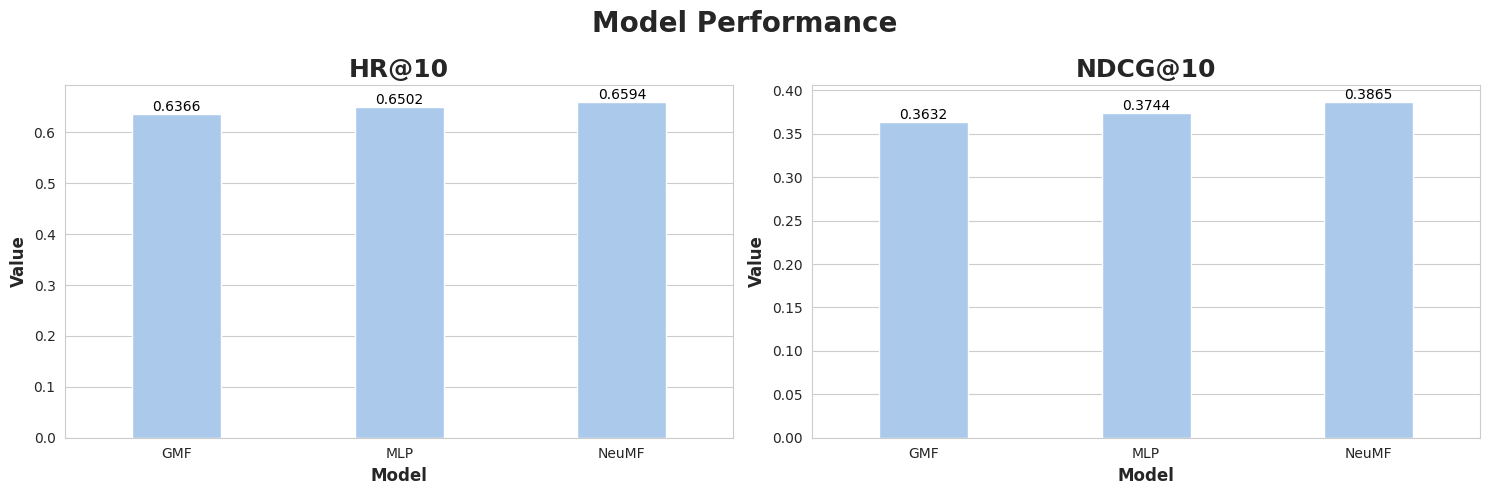

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Model': ['GMF', 'MLP', 'NeuMF', 'GMF', 'MLP', 'NeuMF'],
    'Metric': ['HR@10', 'HR@10', 'HR@10', 'NDCG@10', 'NDCG@10', 'NDCG@10'],
    'Value': [0.6366, 0.6502, 0.6594, 0.3632, 0.3744, 0.3865]
}

df = pd.DataFrame(data)

sns.set_style("whitegrid")
sns.set_palette("pastel")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

bar1 = sns.barplot(x='Model', y='Value', data=df[df['Metric'] == 'HR@10'], ax=axs[0], width=0.4)
axs[0].set_title('HR@10', fontsize=18, fontweight='bold')
axs[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Value', fontsize=12, fontweight='bold')

for p in bar1.patches:
    bar1.text(p.get_x() + p.get_width() / 2., p.get_height(), '{0:.4f}'.format(p.get_height()), 
            fontsize=10, color='black', ha='center', va='bottom')

bar2 = sns.barplot(x='Model', y='Value', data=df[df['Metric'] == 'NDCG@10'], ax=axs[1], width=0.4)
axs[1].set_title('NDCG@10', fontsize=18, fontweight='bold')
axs[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Value', fontsize=12, fontweight='bold')

for p in bar2.patches:
    bar2.text(p.get_x() + p.get_width() / 2., p.get_height(), '{0:.4f}'.format(p.get_height()), 
            fontsize=10, color='black', ha='center', va='bottom')

fig.suptitle('Model Performance', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

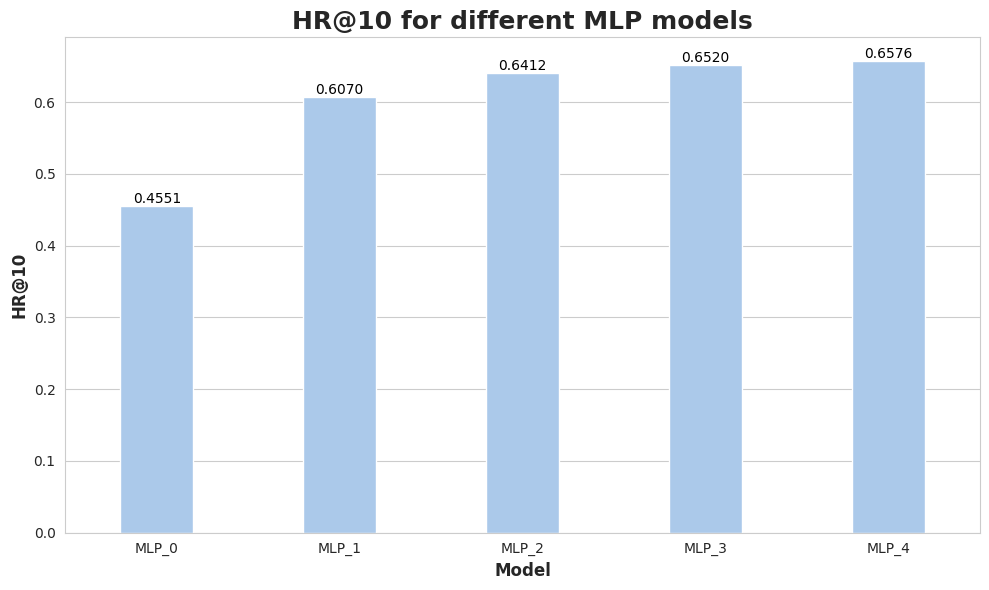

In [12]:
data = {
    'Model': ['MLP_0', 'MLP_1', 'MLP_2', 'MLP_3', 'MLP_4'],
    'HR@10': [0.4551, 0.6070, 0.6412, 0.6520, 0.6576]
}

df = pd.DataFrame(data)

sns.set_style("whitegrid")
sns.set_palette("pastel")


plt.figure(figsize=(10, 6))

bar = sns.barplot(x='Model', y='HR@10', data=df, width=0.4)


for p in bar.patches:
    bar.text(p.get_x() + p.get_width() / 2., p.get_height(), '{0:.4f}'.format(p.get_height()), 
            fontsize=10, color='black', ha='center', va='bottom')

plt.title('HR@10 for different MLP models', fontsize=18, fontweight='bold')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('HR@10', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()